## Druga domača naloga
Opravljanje domačih nalog je **obvezno**. Uspešno rešene domače naloge so **pogoj za pristop k izpitu**. Rok za oddajo je **torek 16. november ob 23:59**.

1. Z 2D **togo preslikavo** $(t_x, t_y, \alpha) = (30 mm,\, -10 mm,\, 30^{\circ})$  preslikajte 2D mrežo kontrolnih točk, ki ste jih ustvarili pri Nalogi 2 v navodilih s funkcijo `getCubicBSpline2DGrid()`. 
  - Izrišite polje deformacij v obliki vektorskega polja z ukazom `quiver` v knjižici `matplotlib.pyplot`. Izrišite vektorje le za premik kontrolnih točk in ne vsake točke v koordinatnem sistemu.
  - Sliko šahovnice iz Naloge 2 v navodilih preslikajte z dobljenim poljem deformacij in jo prikažite.

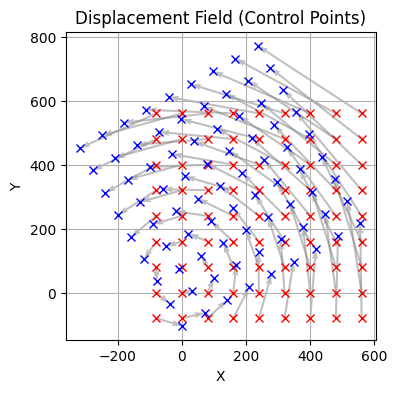

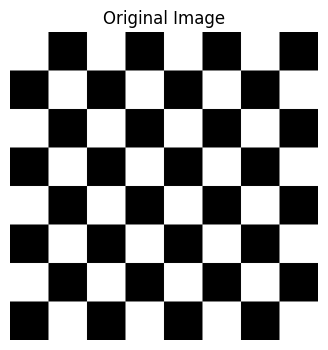

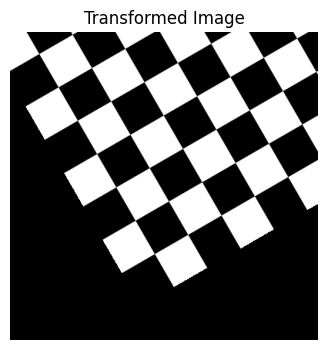

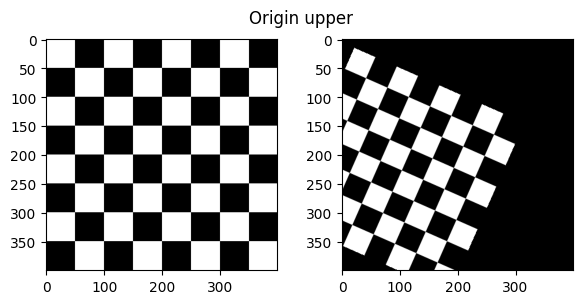

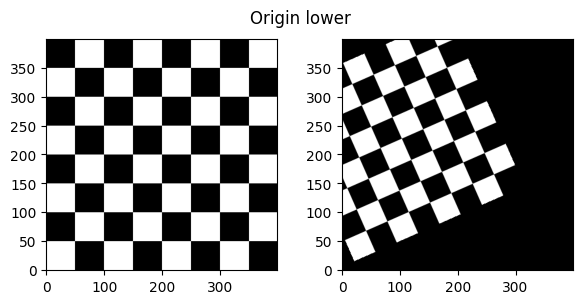

In [43]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interpn

def B0(u):
    # YOUR CODE HERE
    return (1 - u) ** 3.0 / 6.0


def B1(u):
    # YOUR CODE HERE
    return (3 * u ** 3 - 6 * u ** 2 + 4) / 6


def B2(u):
    # YOUR CODE HERE
    return (-3 * u ** 3 + 3 * u ** 2 + 3 * u + 1) / 6


def B3(u):
    # YOUR CODE HERE
    return u ** 3 / 6


B = [B0, B1, B2, B3]

def interp2(xi, yi, x, y, f, order=1, **kwargs):
    f = np.asarray(f)
    xi, yi = np.asarray(xi), np.asarray(yi)

    if x is not None:
        x = np.asarray(x)
        if x.size != f.shape[1]:
            raise IndexError('Length of vector x must match ' \
                'the number of columns of f.')
        indx = (xi - x[0])*((x.size - 1)/(x[-1] - x[0]))
    else:
        indx = xi

    if y is not None:
        y = np.asarray(y)
        if y.size != f.shape[0]:
            raise IndexError('Length of vector y must match ' \
                'the number of rows of f.')
        indy = (yi - y[0])*((y.size - 1)/(y[-1] - y[0]))
    else:
        indy = yi

    return map_coordinates(f, np.asarray([indy, indx]),
                           order=order)

def getCubicBSpline2DGrid(iImageSize, iStep):
    dx, dy = iImageSize

    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)

    X, Y = np.meshgrid(
        np.arange(-iStep[0], np.ceil(dx / iStep[0] + 3) * iStep[0], iStep[0]),
        np.arange(-iStep[1], np.ceil(dy / iStep[1] + 3) * iStep[1], iStep[1])
    )

    return X, Y

def translateAndRotate(tx, ty, alpha):
    T = np.array([ [1, 0, tx],
                    [0, 1, ty],
                    [0, 0, 1] 
                ], dtype=np.float32)
    
    R = np.array([
        [np.cos(alpha), -np.sin(alpha), 0],
        [np.sin(alpha), np.cos(alpha), 0],
        [0, 0, 1]
    ], dtype=np.float32)

    return np.dot(R, T)

def ptTransform(T, iX, iY):
    iX = iX.flatten()
    iY = iY.flatten()
    iXY = np.vstack((iX, iY, np.ones(iX.shape)))

    oXY = np.dot(T, iXY)
    return oXY[0], oXY[1]

def getChessBoardImage(iImage, iArraySize):
    field = [255*np.ones(shape=(iArraySize, iArraySize)),
             np.zeros(shape=(iArraySize, iArraySize))]
    
    dx, dy = iImage.shape

    board = []
    for j in range(dy):
        row = []
        for i in range(dx):
            row.append(field[(i+j)%2])
        board.append(np.hstack(row))
    board = np.vstack(board)

    return board[:dx, :dy]

def imTransform2d(img, T):
    H, W = img.shape

    x = np.arange(W)
    y = np.arange(H)

    dx, dy = x[1] - x[0], y[1] - y[0]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    xt = np.arange(xmin, xmax + dx, dx)
    yt = np.arange(ymin, ymax + dy, dy)

    Yt, Xt = np.meshgrid(yt, xt, indexing='ij')
    Xi, Yi = ptTransform(T, Xt, Yt)

    oimg = interp2(Xi, Yi, x, y, img.astype(np.float32), order=1)

    return oimg

def getCubicBSpline2DDeformation(iImageSize, iCPx, iCPy, iStep):
    dy, dx = iImageSize
    gx, gy = np.meshgrid(np.arange(dx), np.arange(dy), indexing='xy')
    gx = np.array(gx, dtype='float64')
    gy = np.array(gy, dtype='float64')

    oGx = np.zeros_like(gx)
    oGy = np.zeros_like(gy)
    i = np.floor(gx / iStep[0])
    j = np.floor(gy / iStep[1])
    u = gx / iStep[0] - i
    v = gy / iStep[1] - j

    for l in (0, 1, 2, 3):
        for m in (0, 1, 2, 3):
            oGx += B[l](u) * B[m](v) * iCPx[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l]
            oGy += B[l](u) * B[m](v) * iCPy[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l]
    return oGx, oGy

def deformImageBSpline2D(iImage, iCPx, iCPy, iStep):
    dy, dx = iImage.shape
    oGx, oGy = getCubicBSpline2DDeformation(iImage.shape, iCPx, iCPy, iStep)

    gx, gy = np.meshgrid(np.arange(dx), np.arange(dy))
    oGy = 2 * gy - oGy
    oGx = 2 * gx - oGx
    # interpolacija
    oImage = interpn((np.arange(dx), np.arange(dy)),
                     iImage.astype('float'),
                     np.dstack((oGx, oGy)),
                     method='linear',
                     bounds_error=False, fill_value=0)

    return oImage

iX, iY = getCubicBSpline2DGrid((400, 400), 80)
T = translateAndRotate(30, -10, np.pi / 6)
oX, oY = ptTransform(T, iX, iY)

plt.figure(figsize=(4, 4))
plt.plot(iX.flatten(), iY.flatten(), 'rx', label='Control Points')
plt.plot(oX, oY, 'bx', label='Transformed Points')
plt.quiver(iX.flatten(), iY.flatten(), oX - iX.flatten(), oY - iY.flatten(), angles='xy', scale_units='xy', scale=1, color='gray', alpha=0.5)
plt.title("Displacement Field (Control Points)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.show()

iImage = getChessBoardImage(np.zeros((400, 400)), 50)
tImage = imTransform2d(iImage, T)
tImage = np.reshape(tImage, iImage.shape)
plt.figure(figsize=(4, 4))
plt.imshow(iImage, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(tImage, cmap='gray')
plt.title("Transformed Image")
plt.axis('off')
plt.show()

boardImg = getChessBoardImage(np.zeros((400, 400)), 50)

x1CP = np.arange(0, 400, 1)
y1CP = np.arange(0, 400, 1)
X, Y = np.meshgrid(x1CP, y1CP)
oX = np.reshape(oX, iX.shape)
oY = np.reshape(oY, iY.shape)
# prikažemo preslikano šahovnico
cbImageDeformed = deformImageBSpline2D(boardImg, oX, oY, (80, 80))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.imshow(boardImg, cmap='gray')
ax2.imshow(cbImageDeformed, cmap='gray')
#ax2.set_xlim([-150,650])
#ax2.set_ylim([650,-150])
f.suptitle('Origin upper')
plt.show()


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.imshow(boardImg, cmap='gray', origin='lower')
ax2.imshow(cbImageDeformed, cmap='gray', origin='lower')
#ax2.set_xlim([-150,650])
#ax2.set_ylim([650,-150])
f.suptitle('Origin lower')
plt.show()

### END SOLUTION

2. Z uporabo knjižnice `SimpleITK` in metodo `SimpleITK.AffineTransform` preizkusite postopek 3D afine poravnave MR slike pacienta na 3D atlas MNI152 (`data/MNI152_T1_1mm.nii.gz`). 
 - Prikažite sredinske rezine 3D MR slike atlasa v smeri vseh treh osi.
 - Poravnajte MR sliko glave pacienta (`data/T1_AD.nii.gz`) na atlas z uporabo 3D afine poravnave. Prikažite sredinske rezine MR slike pacienta v smeri vseh treh osi pred in po poravnavi na atlas.

Atlas Image:
Size: (182, 218, 182), Spacing: (1.0, 1.0, 1.0), Origin: (-90.0, 126.0, -72.0)
Patient Image:
Size: (166, 256, 256), Spacing: (1.2030534744262695, 0.9419615864753723, 0.9410962462425232), Origin: (-98.9999008178711, -155.04400634765625, -140.1062469482422)


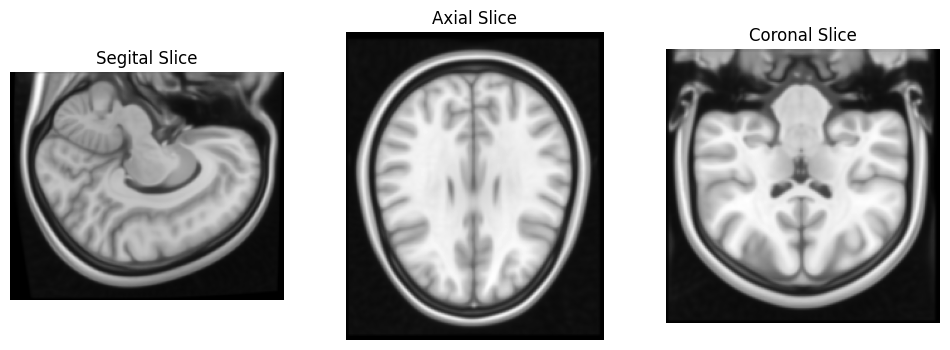

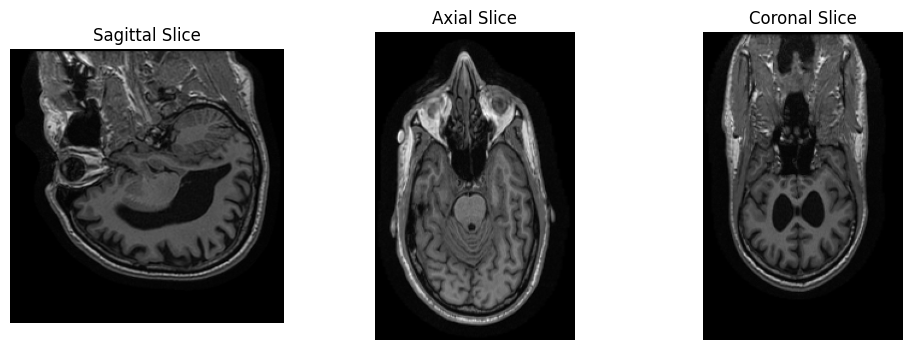

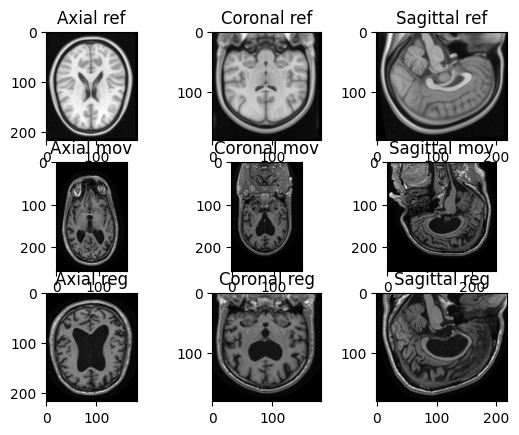

In [45]:
### BEGIN SOLUTION
import SimpleITK as sitk
atlas_path = 'data/MNI152_T1_1mm.nii.gz'
atlas = sitk.ReadImage(atlas_path, sitk.sitkFloat32)
atlas_slice_axial = sitk.GetArrayFromImage(atlas)[100, :, :]
atlas_slice_coronal = sitk.GetArrayFromImage(atlas)[:, 100, :]
atlas_slice_segital = sitk.GetArrayFromImage(atlas)[:, :, 100]

img_path = 'data/T1_AD.nii.gz'
img = sitk.ReadImage(img_path, sitk.sitkFloat32)
img_slice_axial = sitk.GetArrayFromImage(img)[100, :, :]
img_slice_coronal = sitk.GetArrayFromImage(img)[:, 100, :]
img_slice_sagittal = sitk.GetArrayFromImage(img)[:, :, 100]

print("Atlas Image:")
print(f"Size: {atlas.GetSize()}, Spacing: {atlas.GetSpacing()}, Origin: {atlas.GetOrigin()}")
print("Patient Image:")
print(f"Size: {img.GetSize()}, Spacing: {img.GetSpacing()}, Origin: {img.GetOrigin()}")

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(atlas_slice_segital, cmap='gray')
plt.title("Segital Slice")
plt.axis('off')
plt.subplot(132)
plt.imshow(atlas_slice_axial, cmap='gray')
plt.title("Axial Slice")
plt.axis('off')
plt.subplot(133)
plt.imshow(atlas_slice_coronal, cmap='gray')
plt.title("Coronal Slice")
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img_slice_sagittal, cmap='gray')
plt.title("Sagittal Slice")
plt.axis('off')
plt.subplot(132)
plt.imshow(img_slice_axial, cmap='gray')
plt.title("Axial Slice")
plt.axis('off')
plt.subplot(133)
plt.imshow(img_slice_coronal, cmap='gray')
plt.title("Coronal Slice")
plt.axis('off')
plt.show()

# inicializacija postopka
R = sitk.ImageRegistrationMethod()
aTr = sitk.AffineTransform(3)
R.SetInitialTransform(aTr, inPlace=True)

R.SetMetricAsMattesMutualInformation(32)
R.SetMetricSamplingPercentage(0.25)
R.SetMetricSamplingStrategy(R.RANDOM)

R.SetOptimizerAsGradientDescentLineSearch(
    learningRate=5.0,
    numberOfIterations=50,
    convergenceMinimumValue=1e-5,
    convergenceWindowSize=5)
R.SetOptimizerScalesFromPhysicalShift()

# zagon poravnave
outTx = R.Execute(atlas, img)

# ustvarjanje izhodne slike
S = sitk.ResampleImageFilter()
S.SetReferenceImage(atlas)
S.SetInterpolator(sitk.sitkLinear)
S.SetDefaultPixelValue(0)
S.SetTransform(outTx)
outImage = S.Execute(img)


im1 = sitk.GetArrayFromImage(atlas) # Transform to numpy array
im2 = sitk.GetArrayFromImage(img)
im3 = sitk.GetArrayFromImage(outImage)
plt.figure()
plt.subplot(3,3,1)
plt.imshow(im1[im1.shape[0]//2,:,:], cmap='gray')
plt.title("Axial ref")
plt.subplot(3,3,2)
plt.imshow(im1[:,im1.shape[1]//2,:], cmap='gray')
plt.title("Coronal ref")
plt.subplot(3,3,3)
plt.imshow(im1[:,:,im1.shape[2]//2], cmap='gray')
plt.title("Sagittal ref")

plt.subplot(3,3,4)
plt.imshow(im2[im2.shape[0]//2,:,:], cmap='gray')
plt.title("Axial mov")
plt.subplot(3,3,5)
plt.imshow(im2[:,im2.shape[1]//2,:], cmap='gray')
plt.title("Coronal mov")
plt.subplot(3,3,6)
plt.imshow(im2[:,:,im2.shape[2]//2], cmap='gray')
plt.title("Sagittal mov")

plt.subplot(3,3,7)
plt.imshow(im3[im3.shape[0]//2,:,:], cmap='gray')
plt.title("Axial reg")
plt.subplot(3,3,8)
plt.imshow(im3[:,im3.shape[1]//2,:], cmap='gray')
plt.title("Coronal reg")
plt.subplot(3,3,9)
plt.imshow(im3[:,:,im3.shape[2]//2], cmap='gray')
plt.title("Sagittal reg")

plt.show()
### END SOLUTION

V datotekah `data/atlas_slice.nii.gz` in `data/AD_slice.nii.gz` se nahajata 2D aksialna rezina možganskega atlasa in pripadajoča rezina afino poravnane slike iz prejšnje točke. 
  - Z B-zlepki poravnajte 2D MR sliko (`data/AD_slice.nii.gz`) na možganski atlas (`data/atlas_slice.nii.gz`). Prikažite sliko poravnave in razlike ter komentirajte rezultat. Preverite vpliv gostote mreže kontrolnih točk na poravnavo. 

itk::simple::BSplineTransform
 BSplineTransform (0x1058f6710)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 74254
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x1058f6810, 0x1058f6a30 ]
   TransformDomainOrigin: [-90.625, -91.625]
   TransformDomainPhysicalDimensions: [182.25, 218.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [8, 8]
   GridSize: [11, 11]
   GridOrigin: [-113.406, -118.906]
   GridSpacing: [22.7812, 27.2812]
   GridDirection: 1 0
0 1




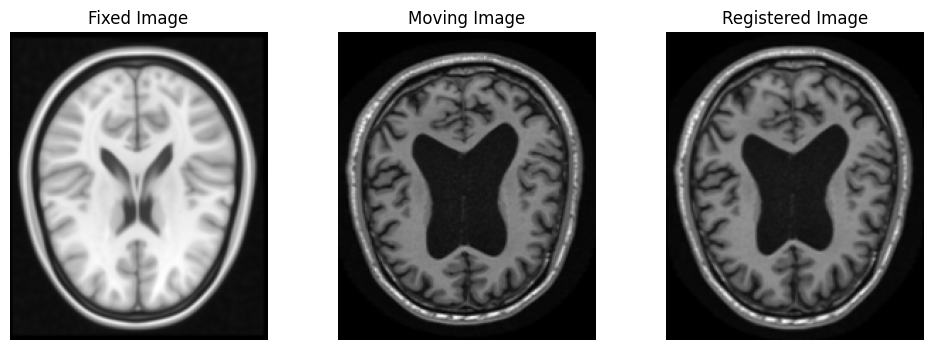

In [28]:
### BEGIN SOLUTION
# nalozi slike
fixed = sitk.ReadImage('data/atlas_slice.nii.gz', sitk.sitkFloat32)
moving = sitk.ReadImage('data/AD_slice.nii.gz', sitk.sitkFloat32)

# inicializacija postopka
R = sitk.ImageRegistrationMethod()

# inicializacija preslikave z B-zlepki
bsplineGrid = 8
bTr = sitk.BSplineTransformInitializer(fixed, [bsplineGrid] * 2)
R.SetInitialTransform(bTr, inPlace=True)

# inicializacija mere podobnosti
R.SetMetricAsMattesMutualInformation(32)
R.SetMetricSamplingPercentage(0.25)
R.SetMetricSamplingStrategy(R.RANDOM)

# inicializacija optimizacije
R.SetOptimizerAsGradientDescentLineSearch(
    learningRate=5.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-5,
    convergenceWindowSize=5)
R.SetOptimizerScalesFromPhysicalShift()

# zagon poravnave
outTx = R.Execute(fixed, moving)
print(outTx)
# ustvarjanje izhodne slike
S = sitk.ResampleImageFilter()
S.SetReferenceImage(fixed)
S.SetInterpolator(sitk.sitkLinear)
S.SetDefaultPixelValue(0)
S.SetTransform(outTx)
outImage = S.Execute(moving)

# prikaz rezultatov
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(sitk.GetArrayFromImage(fixed), cmap='gray')
plt.title("Fixed Image")
plt.axis('off')
plt.subplot(132)
plt.imshow(sitk.GetArrayFromImage(moving), cmap='gray')
plt.title("Moving Image")
plt.axis('off')
plt.subplot(133)
plt.imshow(sitk.GetArrayFromImage(outImage), cmap='gray')
plt.title("Registered Image")
plt.axis('off')
plt.show()

### END SOLUTION